In [1]:
import tensorflow as tf
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
factors = [1.5, 1, 2, 3, 4, 5, 6]
elements = ['C', 'Fe', 'He', 'N', 'O', 'p']

Epoch 1/50
1293/1293 [==============================] - 91s 70ms/step - loss: 0.4741 - val_loss: 0.2007
Epoch 2/50
1293/1293 [==============================] - 95s 74ms/step - loss: 0.2132 - val_loss: 0.2435
Epoch 3/50
1293/1293 [==============================] - 94s 73ms/step - loss: 0.2008 - val_loss: 0.1771
Epoch 4/50
1293/1293 [==============================] - 94s 73ms/step - loss: 0.1898 - val_loss: 0.1824
Epoch 5/50
1293/1293 [==============================] - 87s 67ms/step - loss: 0.1878 - val_loss: 0.1757
Epoch 6/50
1293/1293 [==============================] - 84s 65ms/step - loss: 0.1855 - val_loss: 0.1848
Epoch 7/50
1293/1293 [==============================] - 75s 58ms/step - loss: 0.1871 - val_loss: 0.1684
Epoch 8/50
1293/1293 [==============================] - 79s 61ms/step - loss: 0.1819 - val_loss: 0.1673
Epoch 9/50
1293/1293 [==============================] - 87s 68ms/step - loss: 0.1792 - val_loss: 0.1732
Epoch 10/50
1293/1293 [==============================] - 101s 78

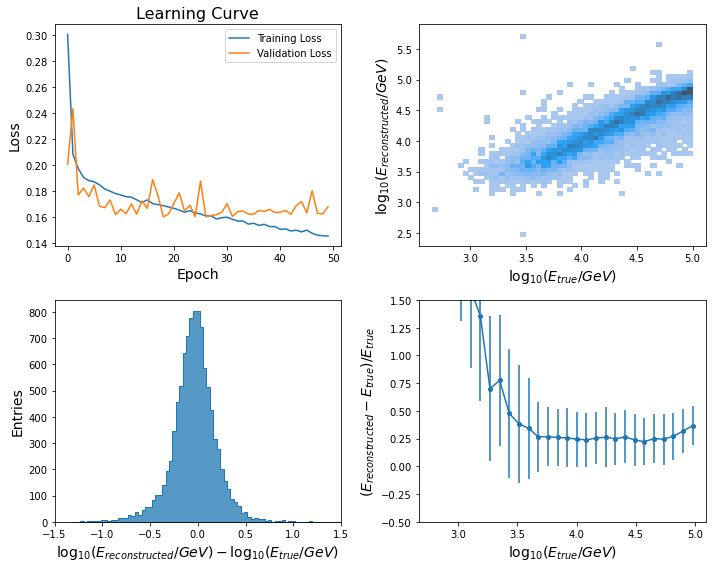

In [25]:
for j in range(6,7):
    Imgs = sorted(glob.glob('./data/*flat_imgsX%s.npy'%str(factors[j])))
    Es = sorted(glob.glob('./data/*flat_true_energyX%s.npy'%str(factors[j])))
    Angles = sorted(glob.glob('./data/*_flat_angleX%s.npy'%str(factors[j])))
    Charges = sorted(glob.glob('./data/*_flat_chargeX%s.npy'%str(factors[j])))

    ################### load input data ######################################
    C = np.load(Imgs[0])
    Fe = np.load(Imgs[1])
    He = np.load(Imgs[2])
    N = np.load(Imgs[3])
    O = np.load(Imgs[4])
    p = np.load(Imgs[5])

    dummy1 = np.concatenate((C, Fe), axis=0)
    dummy2 = np.concatenate((dummy1, He), axis=0)
    dummy3 = np.concatenate((dummy2, N), axis=0)
    dummy4 = np.concatenate((dummy3, O), axis=0)
    all_elem_Img = np.concatenate((dummy4, p), axis=0)

    C = np.load(Es[0])
    Fe = np.load(Es[1])
    He = np.load(Es[2])
    N = np.load(Es[3])
    O = np.load(Es[4])
    p = np.load(Es[5])

    dummy1 = np.concatenate((C, Fe), axis=0)
    dummy2 = np.concatenate((dummy1, He), axis=0)
    dummy3 = np.concatenate((dummy2, N), axis=0)
    dummy4 = np.concatenate((dummy3, O), axis=0)
    all_elem_E = np.concatenate((dummy4, p), axis=0)

    C = np.load(Angles[0])
    Fe = np.load(Angles[1])
    He = np.load(Angles[2])
    N = np.load(Angles[3])
    O = np.load(Angles[4])
    p = np.load(Angles[5])

    dummy1 = np.concatenate((C, Fe), axis=0)
    dummy2 = np.concatenate((dummy1, He), axis=0)
    dummy3 = np.concatenate((dummy2, N), axis=0)
    dummy4 = np.concatenate((dummy3, O), axis=0)
    all_elem_Angle = np.concatenate((dummy4, p), axis=0)
    
    C = np.load(Charges[0])
    Fe = np.load(Charges[1])
    He = np.load(Charges[2])
    N = np.load(Charges[3])
    O = np.load(Charges[4])
    p = np.load(Charges[5])

    dummy1 = np.concatenate((C, Fe), axis=0)
    dummy2 = np.concatenate((dummy1, He), axis=0)
    dummy3 = np.concatenate((dummy2, N), axis=0)
    dummy4 = np.concatenate((dummy3, O), axis=0)
    all_elem_Charge = np.concatenate((dummy4, p), axis=0)    
    

    #################### define the model ######################################
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
    from tensorflow.keras.layers import concatenate

    Img = all_elem_Img
    E = all_elem_E
    Angle = all_elem_Angle
    Charge = all_elem_Charge

    X = Img
    y = np.log10(E)
    X0 = Angle

    img_rows, img_cols = X[0].shape
    input_shape = (img_rows, img_cols, 1)

    X = X.reshape(X.shape[0], img_rows, img_cols, 1)
    X = X.astype('float32')
    X0 = np.reshape(Angle, (len(X0),1))

    shuffler = np.random.permutation(len(X))
    X_new = X[shuffler]
    y_new = y[shuffler]
    X0_new = X0[shuffler]

    X_train, X_val, y_train, y_val = train_test_split(X_new[:-10000], y_new[:-10000], test_size=0.15, shuffle=False)
    X0_train, X0_val = train_test_split(X0_new[:-10000], test_size=0.15, shuffle=False)
    X_test = X_new[-10000:]
    X0_test = X0_new[-10000:]
    y_test = y_new[-10000:]
    
    #Only use charge for further checks, not in training 
    Charge = all_elem_Charge[shuffler]
    Charge_train, Charge_val = train_test_split(Charge[:-10000], test_size=0.15, shuffle=False)
    Charge_test = Charge[-10000:]

    #Define layers
    Input_imgs = Input(shape=input_shape)
    Input_angle = Input(shape=(1))
    Conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(Input_imgs)
    Pool1 = MaxPooling2D(pool_size=(2, 2))(Conv1)
    Conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(Pool1)
    Pool2 = MaxPooling2D(pool_size=(2, 2))(Conv2)
    Conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(Pool2)
    Drop = Dropout(0.2)(Conv3)
    Flat = Flatten()(Drop)
    Concat = concatenate([Flat, Input_angle])

    Hidden1 = Dense(128, activation='relu')(Concat)
    Output = Dense(1, activation='linear')(Hidden1)

    #Define the model
    model = Model(inputs=[Input_imgs, Input_angle], outputs=Output)
    model.compile(loss=tf.keras.losses.mae,
                  optimizer=tf.keras.optimizers.Adam())

    #Train
    epochs = 50
    history = model.fit([X_train, X0_train], y_train,
              batch_size=32,
              epochs=epochs,
              verbose=1,
              validation_data=([X_val, X0_val], y_val))
    
    #Test
    prediction = model.predict([X_test, X0_test]) #Get predicted energy and restore true energy from log scale
    prediction = np.reshape(prediction, y_test.shape)
    test_predicted_energy = np.power(10, prediction)
    test_true_energy = np.power(10, y_test)
    loss = np.divide(abs(test_true_energy - test_predicted_energy), test_true_energy)


    bins = np.logspace(2, 6, 50)
    med_y = []
    med_x = []
    err = []
    for i in range(len(bins)-1):
        idx = np.where( (test_true_energy > bins[i]) & (test_true_energy<bins[i+1]) )[0]
        if len(idx)==0: continue
        med_y.append( np.median(loss[idx]) )
        med_x.append( (bins[i]+bins[i+1])/2 )
        err.append( abs((np.percentile(loss[idx], 84) - np.percentile(loss[idx], 16))/2) )

    plt.figure(figsize=(10,8))

    plt.subplot(221) #learning curve
    mae=history.history['loss']
    val_mae=history.history['val_loss']
    epochs_range = range(epochs)
    plt.plot(epochs_range, mae, label='Training Loss')
    plt.plot(epochs_range, val_mae, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Learning Curve', fontsize=16)
    plt.tight_layout()

    plt.subplot(222)
    sns.histplot(x=np.log10(test_true_energy), y=np.log10(test_predicted_energy), bins=50)
    plt.xlabel(r'$\log_{10}(E_{true}/GeV)$', fontsize=14)
    plt.ylabel(r'$\log_{10}(E_{reconstructed}/GeV)$', fontsize=14)
    #plt.xlim(2,5)
    #plt.ylim(2,5)
    plt.tight_layout()

    plt.subplot(223)
    sns.histplot((np.log10(test_predicted_energy) - np.log10(test_true_energy) ), bins=100, element='step')
    plt.xlabel('$\log_{10}(E_{reconstructed}/GeV)-\log_{10}(E_{true}/GeV)$', fontsize=14)
    plt.ylabel('Entries', fontsize=14)
    plt.xlim(-1.5,1.5)
    plt.tight_layout()

    plt.subplot(224)
    plt.errorbar(np.log10(med_x[1:]), med_y[1:], yerr=err[1:], marker='o',ms=4, ls='-')
    plt.ylim(-0.5, 1.5)
    plt.xlabel('$\log_{10}(E_{true}/GeV)$', fontsize=14)
    plt.ylabel('$(E_{reconstructed}-E_{true})/E_{true}$', fontsize=14)
    plt.tight_layout()

    #
    figname = './plots/' + 'all_elemX' + str(factors[j]) + '_loss' + '%0.3f'%np.median(loss) + '.jpg' 
    plt.savefig(figname)

    modelname = './models/' + 'all_elemX' + str(factors[j]) + '_loss' + '%0.3f'%np.median(loss) +'.h5'
    model.save(modelname)

    outname = './models/' + 'all_elemX' + str(factors[j]) + '_loss' + '%0.3f'%np.median(loss) + '.npy'
    np.save(outname, [Charge_test, test_predicted_energy, test_true_energy])